In [1]:
import phonopy
import numpy as np
import matplotlib.pyplot as plt
import yaml

import types
from phonopy.structure.atoms import PhonopyAtoms

from modules.phonon_parser import parse_band_yaml
from ase import Atoms
from ase.build import make_supercell
from ase.io.espresso import read_espresso_in

In [2]:
with open("example/band_single.yaml", "r") as f:
    data = yaml.safe_load(f)
unit_cell_phonons, unit_cell_meta = parse_band_yaml(data)

In [3]:
def meta_to_ase_atoms(meta):
    """
    Convert the 'meta' dict from parse_band_yaml to an ASE Atoms object.
    Requires ASE to be installed.
    """
    

    # Lattice: (3,3) array in Angstrom
    lattice = meta.get("lattice")
    if lattice is None:
        raise ValueError("meta['lattice'] is missing or invalid")

    # Atoms: list of dicts with 'symbol', 'frac', 'mass'
    atoms = meta.get("atoms")
    if not atoms:
        raise ValueError("meta['atoms'] is missing or empty")

    symbols = [a["symbol"] for a in atoms]
    scaled_positions = [a["frac"] for a in atoms]
    masses = [a.get("mass") for a in atoms]

    # Construct ASE Atoms object
    ase_atoms = Atoms(
        symbols=symbols,
        scaled_positions=scaled_positions,
        cell=lattice,
        pbc=True,
        masses=masses,
    )
    return ase_atoms


In [11]:
def get_dx(eq, ts):
    """
    Compute atomic displacements (dx) from eq to ts, considering periodic boundary conditions.
    Returns an array of shape (natoms, 3) in Cartesian coordinates.
    Expects eq and ts to be ASE Atoms objects.
    """
    # Get lattice vectors (3,3)
    lattice = eq.get_cell()
    # Get fractional positions (N,3)
    frac_eq = eq.get_scaled_positions()
    frac_ts = ts.get_scaled_positions()
    # Compute shortest fractional displacement (wrap into [-0.5, 0.5))
    dfrac = frac_ts - frac_eq
    dfrac = (dfrac + 0.5) % 1.0 - 0.5
    # Convert to Cartesian
    dx = np.dot(dfrac, lattice)
    return dx

In [9]:
def perp_vec_T_to_line_IF(I_atoms: Atoms, F_atoms: Atoms, T_atoms: Atoms) -> np.ndarray:
    """
    Compute the perpendicular vector from T to the line through I and F,
    treating the system as a single point in R^{3N} (N = number of atoms).
    Wrapping to the nearest image is done in fractional coordinates.

    Parameters
    ----------
    I_atoms, F_atoms, T_atoms : ase.Atoms
        Must have the same number/order of atoms. Cells should be identical
        (or at least use the same metric); the lattice from I_atoms is used.

    Returns
    -------
    v_cart : (N, 3) np.ndarray
        Cartesian displacement vectors from T to its orthogonal projection P on line IF,
        i.e., v_cart = P - T. Flattening this gives the 3N-dimensional perpendicular vector.

    Raises
    ------
    ValueError
        If I and F coincide in the 3N sense (degenerate line).
    """
    # Lattice (3,3)
    lattice = I_atoms.get_cell()  # assumes same cell for all images

    # Fractional positions (N,3)
    frac_I = I_atoms.get_scaled_positions()
    frac_F = F_atoms.get_scaled_positions()
    frac_T = T_atoms.get_scaled_positions()

    # Shortest-image fractional displacements from I
    dfrac_IF = (frac_F - frac_I + 0.5) % 1.0 - 0.5   # F - I
    dfrac_IT = (frac_T - frac_I + 0.5) % 1.0 - 0.5   # T - I

    # Convert to Cartesian per-atom displacements (N,3)
    dcart_IF = dfrac_IF @ lattice  # direction a in blocks of (N,3)
    dcart_IT = dfrac_IT @ lattice  # w = T - I

    # Flatten to 3N vectors for the projection math
    a = dcart_IF.reshape(-1)       # line direction (F - I) in R^{3N}
    w = dcart_IT.reshape(-1)       # (T - I) in R^{3N}

    aa = np.dot(a, a)
    if aa == 0.0:
        raise ValueError("I and F coincide (undefined line).")

    # Projection of w onto a in R^{3N}
    lam = np.dot(w, a) / aa
    w_parallel = lam * a

    # Perpendicular vector from T to the line: v = P - T = w_parallel - w
    v_flat = w_parallel - w

    # Back to (N,3) Cartesian
    v_cart = v_flat.reshape(dcart_IT.shape)
    return v_cart

In [4]:
unit_cell_atoms = meta_to_ase_atoms(unit_cell_meta)

In [5]:
print(unit_cell_phonons["frequencies"])

[[ 2.72437781  2.72437781  3.89713954 ... 18.49376709 18.49376709
  21.22682253]
 [ 2.72326193  2.72326193  3.89694501 ... 18.49388915 18.49388915
  21.22537185]
 [ 2.71991313  2.71991313  3.89636259 ... 18.49425481 18.49425481
  21.22097385]
 ...
 [ 2.59397926  2.615415    2.64721926 ... 13.75119897 18.32411736
  22.01454399]
 [ 2.600114    2.60857112  2.64698633 ... 13.74867845 18.32359116
  22.01509589]
 [ 2.60628298  2.60628298  2.63510246 ... 13.74784317 18.3234155
  22.01527893]]


In [6]:
with open("example/band_ts2-3.yaml", "r") as f:
    data = yaml.safe_load(f)
ts_phonons, ts_meta = parse_band_yaml(data)
ts_atoms = meta_to_ase_atoms(ts_meta)

In [7]:
with open("example/band_eq2.yaml", "r") as f:
    data = yaml.safe_load(f)
eq_phonons, eq_meta = parse_band_yaml(data)
eq_atoms = meta_to_ase_atoms(eq_meta)

In [8]:
with open("example/eq3.in","r") as in_file:
    fin_atoms = read_espresso_in(in_file)

In [ ]:
dx = perp_vec_T_to_line_IF(eq_atoms, fin_atoms, ts_atoms)
print(dx)

[[ 0.00000000e+00 -1.12026526e-01 -7.93904280e-02]
 [ 0.00000000e+00 -1.58143220e-02 -1.64591249e-02]
 [ 0.00000000e+00 -5.25841566e-02  7.01689695e-02]
 [ 0.00000000e+00 -2.22971854e-02  1.46007457e-02]
 [ 0.00000000e+00  8.68951590e-02 -1.04889629e-01]
 [ 0.00000000e+00  1.02767820e-02 -1.70325129e-02]
 [ 0.00000000e+00  4.27065146e-02  3.97630376e-02]
 [ 0.00000000e+00  1.34514754e-02  1.37473536e-02]
 [ 0.00000000e+00 -8.33202310e-02  2.89229419e-01]
 [ 0.00000000e+00 -2.30105929e-02  7.17888650e-03]
 [ 0.00000000e+00 -5.56209924e-02  4.56046110e-02]
 [ 0.00000000e+00 -1.96599517e-02 -1.21675636e-02]
 [ 0.00000000e+00  7.85147394e-02  1.62925221e-01]
 [ 0.00000000e+00  1.43442784e-02  1.05000481e-02]
 [ 0.00000000e+00  6.31439577e-02 -6.16582280e-02]
 [ 0.00000000e+00  1.43155222e-02  1.31597320e-02]
 [ 0.00000000e+00  3.67435720e-01 -1.02919739e-01]
 [ 0.00000000e+00 -1.40904829e-02 -2.03048370e-02]
 [ 0.00000000e+00  4.92427241e-02  5.89124706e-02]
 [ 0.00000000e+00  2.22184223e-

In [15]:
print(eq_phonons["frequencies"][:,0])
print(ts_phonons["frequencies"][:,1])

[-3.00954915 -3.00975205 -3.01035679 -3.01135147 -3.01271656 -3.0144252
 -3.01644366 -3.01873181 -3.02124361 -3.02392761 -3.0267273  -3.02958157
 -3.03242498 -3.03518815 -3.03779805 -3.04017842 -3.04225024 -3.0439323
 -3.04514189 -3.04579558 -3.04581017 -3.04510365 -3.04359629 -3.04121179
 -3.03787841 -3.0335302  -3.02810818 -3.02156161 -3.01384927 -3.00494082
 -2.99481831 -2.98347774 -2.97093095 -2.95720764 -2.94235777 -2.9264542
 -2.9095957  -2.89191031 -2.87355878 -2.85473824 -2.83568545 -2.81667933
 -2.79804198 -2.78013708 -2.76336454 -2.74814978 -2.73492675 -2.72411417
 -2.71608622 -2.71114077 -2.70947014 -2.70947014 -2.71037805 -2.71308048
 -2.7175149  -2.72358156 -2.73114949 -2.74006376 -2.75015323 -2.76123786
 -2.77313539 -2.78566671 -2.79866011 -2.81195431 -2.82540047 -2.83886332
 -2.85222168 -2.86536841 -2.87821013 -2.89066664 -2.90267019 -2.9141648
 -2.92510539 -2.93545702 -2.94519412 -2.95429973 -2.96276477 -2.97058736
 -2.97777212 -2.98432955 -2.99027539 -2.99563    -3.000

In [16]:
eq_freqs = np.array(eq_phonons["frequencies"][:,:-1])
ts_freqs = np.array(ts_phonons["frequencies"][:,1:])
diff = ts_freqs - eq_freqs
avg_diff = np.mean(diff)
print("Average difference between TS and EQ frequencies:", avg_diff)


Average difference between TS and EQ frequencies: 0.6392691062533992


In [17]:
print(np.array(eq_phonons["eigenvectors"]).shape)

(204, 123, 41, 3)


In [14]:
eq_ev = np.array(eq_phonons["eigenvectors"])
ts_ev = np.array(ts_phonons["eigenvectors"])
min_dv = 1000
min_ind = 10
for i in range(eq_ev.shape[1]):
    dv = eq_ev[0,i,:,:] - ts_ev[0,30,:,:]
    dv_mean = np.mean(np.abs(dv))
    if dv_mean < min_dv:
        min_dv = dv_mean
        min_ind=i

print(min_dv)
print(min_ind)

0.06037613839778865
26


In [16]:
def mac_mass(u, v, masses):
    # u, v: complex (3N,) vectors; masses: (N,) atomic masses
    M = np.repeat(masses, 3)              # (3N,)
    # phase align v to u under mass metric
    flat_u = u.flatten()
    flat_v = v.flatten()
    num = np.vdot(flat_u * M, flat_v)               # u^† M v
    v_aligned = flat_v * np.exp(-1j * np.angle(num))
    num_aligned = np.vdot(flat_u * M, v_aligned)
    den = np.sqrt(np.vdot(flat_u * M, flat_u) * np.vdot(v_aligned * M, v_aligned))
    return float(np.abs(num_aligned)**2 / (den.real**2))  # MAC in [0,1]

def best_match(u, V, masses):
    # V: array shape (n_modes, 3N)
    scores = np.array([mac_mass(u, v, masses) for v in V])
    j = int(np.argmax(scores))
    return j, float(scores[j])

print(best_match(ts_ev[0,8,:-1,:],eq_ev[0,:,:-1,:],ts_atoms.get_masses()[:-1]))

(4, 0.2200249122549499)


In [17]:
# --- inputs you already have ---
# unit_cell_atoms: ASE Atoms of the primitive/ unit cell
# unit_cell_phonons["eigenvectors"]: shape [nq, nbranches, natoms, 3] (complex allowed)
# qpoints_frac: array-like of shape [nq, 3] with q in fractional reciprocal coords
# P: 3x3 integer supercell matrix (use diagonal for simple repeats). Example:
P = np.diag([2, 2, 2])  # (nx, ny, nz)

# Build the supercell atoms (fixing the small typo in your snippet)
supercell_atoms = make_supercell(unit_cell_atoms, P)

unit_eigvecs = np.asarray(unit_cell_phonons["eigenvectors"])  # [nq, nbranches, natoms, 3]
qpoints_frac  = np.asarray(unit_cell_phonons["qpoints_frac"], dtype=float)         # [nq, 3]
nq, nbranches, natoms, _ = unit_eigvecs.shape

# Extract repeats per direction from P (assumes diagonal supercell here)
nx, ny, nz = np.diag(P).astype(int)

def build_supercell_mode_stepwise(eigvec_uc, q_frac, nx, ny, nz):
    """
    Stepwise replicate eigenvector along x, then y, then z,
    appending blocks multiplied by exp(2πi * (q·T)) in fractional coords.
    eigvec_uc: (natoms, 3) complex
    q_frac: (3,) fractional reciprocal coords (q1, q2, q3)
    returns: (natoms*nx*ny*nz, 3) complex eigenvector for the supercell
    """
    # Ensure complex dtype
    mode = np.asarray(eigvec_uc, dtype=np.complex128)

    # --- X replication ---
    # start with the base block
    blocks_x = [mode]
    if nx > 1:
        phase_x = np.exp(2j * np.pi * q_frac[0] * np.arange(1, nx))  # phases for 1..nx-1
        for ph in phase_x:
            blocks_x.append(mode * ph)
    mode_x = np.concatenate(blocks_x, axis=0)  # (natoms*nx, 3)

    # --- Y replication ---
    blocks_y = [mode_x]
    if ny > 1:
        phase_y = np.exp(2j * np.pi * q_frac[1] * np.arange(1, ny))
        for ph in phase_y:
            blocks_y.append(mode_x * ph)
    mode_xy = np.concatenate(blocks_y, axis=0)  # (natoms*nx*ny, 3)

    # --- Z replication ---
    blocks_z = [mode_xy]
    if nz > 1:
        phase_z = np.exp(2j * np.pi * q_frac[2] * np.arange(1, nz))
        for ph in phase_z:
            blocks_z.append(mode_xy * ph)
    mode_xyz = np.concatenate(blocks_z, axis=0)  # (natoms*nx*ny*nz, 3)

    return mode_xyz

# Build all supercell eigenvectors with correct Bloch phases
supercell_eigenvectors = np.empty((nq, nbranches, natoms*nx*ny*nz, 3), dtype=np.complex128)

for iq in range(nq):
    qf = qpoints_frac[iq]  # (q1, q2, q3) in fractional coords
    for b in range(nbranches):
        eig_uc = unit_eigvecs[iq, b]            # (natoms, 3), complex
        eig_sc = build_supercell_mode_stepwise(eig_uc, qf, nx, ny, nz)
        supercell_eigenvectors[iq, b] = eig_sc

# supercell_eigenvectors has shape [nq, nbranches, supercell_natoms, 3] (complex)


In [18]:
print(supercell_atoms.get_masses().shape)
masses = supercell_atoms.get_masses()  # shape (40,)
masses_40x3 = np.tile(masses[:, None], (1, 3))  # shape (40, 3)
print(masses_40x3.shape)


(40,)
(40, 3)


In [19]:
def pbc_diff(a, b, cell):
    """
    Compute minimum-image difference between a and b under PBC.
    a, b: (3,) arrays (fractional coordinates)
    cell: (3,3) cell matrix (cartesian vectors as rows)
    Returns: cartesian vector from a to b (minimum image)
    """
    # Convert to fractional if not already
    # a, b are fractional
    d = b - a
    d -= np.round(d)  # wrap to [-0.5,0.5)
    return np.dot(d, cell)  # cartesian

# Get positions and symbols for mapping
supercell_pos = supercell_atoms.get_positions()  # (Nsuper, 3)
supercell_frac = supercell_atoms.get_scaled_positions()
supercell_syms = np.array(supercell_atoms.get_chemical_symbols())

ts_pos = ts_atoms.get_positions()  # (Nts, 3)
ts_frac = ts_atoms.get_scaled_positions()
ts_syms = np.array(ts_atoms.get_chemical_symbols())

cell = supercell_atoms.get_cell()  # (3,3)

# For each ts_atom (except last), find closest supercell atom of same type
mapping = []
used_super_idx = set()
for i in range(len(ts_atoms)-1):
    sym = ts_syms[i]
    frac = ts_frac[i]
    # Find all supercell atoms of same type not yet used
    candidates = np.where(supercell_syms == sym)[0]
    min_dist = None
    min_j = None
    for j in candidates:
        if j in used_super_idx:
            continue
        dvec = pbc_diff(frac, supercell_frac[j], np.eye(3))  # use fractional cell for wrapping
        # Convert to cartesian
        dvec_cart = np.dot(dvec, cell)
        dist = np.linalg.norm(dvec_cart)
        if (min_dist is None) or (dist < min_dist):
            min_dist = dist
            min_j = j
    if min_j is not None:
        mapping.append(min_j)
        used_super_idx.add(min_j)
    else:
        raise RuntimeError(f"No matching supercell atom found for ts atom {i} ({sym})")

# Now rearrange supercell_eigenvectors to match ts_atoms order (except last atom)
# supercell_eigenvectors: [nq][nbranches][supercell_natoms][3]

rearranged_supercell_eigenvectors = []
for q in range(len(supercell_eigenvectors)):
    q_eigvecs = []
    for b in range(len(supercell_eigenvectors[q])):
        eigvecs = supercell_eigenvectors[q][b]  # [supercell_natoms, 3]
        # Rearranged: [eigvecs[mapping[0]], eigvecs[mapping[1]], ..., eigvecs[mapping[-1]]]
        eigvecs_rearr = np.array([eigvecs[j] for j in mapping])
        q_eigvecs.append(eigvecs_rearr)
    rearranged_supercell_eigenvectors.append(q_eigvecs)
# rearranged_supercell_eigenvectors: [nq][nbranches][len(ts_atoms)-1][3]


In [23]:
print(np.array(rearranged_supercell_eigenvectors).shape)
print(np.array(unit_cell_phonons["eigenvectors"]).shape)

(306, 15, 40, 3)
(306, 15, 5, 3)


In [ ]:
mass_weight = True
# Calculate the modulus of projection of dx[:-1] onto each eigenvector
# rearranged_supercell_eigenvectors: [nq][nbranches][len(ts_atoms)-1][3]
# dx: [len(ts_atoms), 3] (assumed from context)
# We want: projections_modulus: [nq, nbranches]

dx_vec = dx[:-1]  # shape: (len(ts_atoms)-1, 3)

if mass_weight: # to be honest, I dont think it shpould be weighted
    masses = np.tile(eq_atoms.get_masses()[:-1].reshape(-1,1), (1,3))
    mass_factor = 1/np.sqrt(masses)
    dx_vec = dx_vec * mass_factor

dx_vec = dx_vec - np.mean(dx_vec, axis=0)

dx_vec_flat = dx_vec.flatten()  # shape: ((len(ts_atoms)-1)*3,)

projections_modulus = []
for q in range(len(rearranged_supercell_eigenvectors)):
    q_proj = []
    for b in range(len(rearranged_supercell_eigenvectors[q])):
        eigvec = rearranged_supercell_eigenvectors[q][b]  # shape: (len(ts_atoms)-1, 3)
        eigvec_flat = eigvec.flatten()  # shape: ((len(ts_atoms)-1)*3,)
        # If eigenvectors are complex, use conjugate for projection
        proj = np.vdot(eigvec_flat, dx_vec_flat)  # vdot does conjugate on first arg  
        q_proj.append(np.abs(proj))
    projections_modulus.append(q_proj)
projections_modulus = np.array(projections_modulus)  # shape: (nq, nbranches)
print(projections_modulus.shape)


(306, 15)


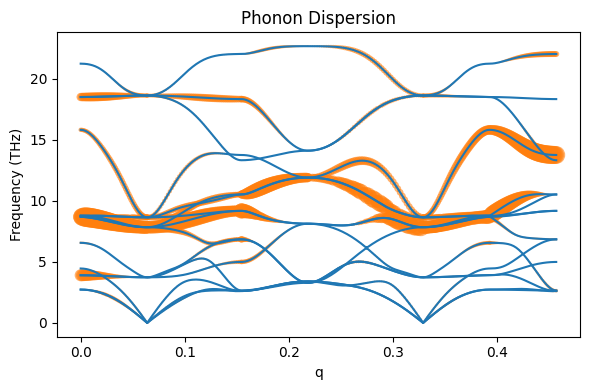

In [23]:
import matplotlib.pyplot as plt

# unit_cell_phonons["frequencies"]: shape [nq, nbranches]
# unit_cell_phonons["q"]: shape [nq]

freqs = np.array(unit_cell_phonons["frequencies"])  # [nq, nbranches]
q = np.array(unit_cell_phonons["qpoints"])  # [nq]

plt.figure(figsize=(6,4))
for b in range(freqs.shape[1]):
    plt.plot(q, freqs[:, b], color="C0")

# Overlay scatter plot: point size proportional to projection_modulus
# Normalize projection_modulus for point size scaling
proj = projections_modulus
min_size = 0
max_size = 200
proj_norm = (proj - proj.min()) / max(proj.max() - proj.min(), 1e-12)
sizes = min_size + proj_norm**2 * (max_size - min_size)

for b in range(freqs.shape[1]):
    plt.scatter(q, freqs[:, b], s=sizes[:, b], color="C1", alpha=0.6, edgecolors='none')

plt.xlabel("q")
plt.ylabel("Frequency (THz)")
plt.title("Phonon Dispersion")
plt.tight_layout()
plt.show()


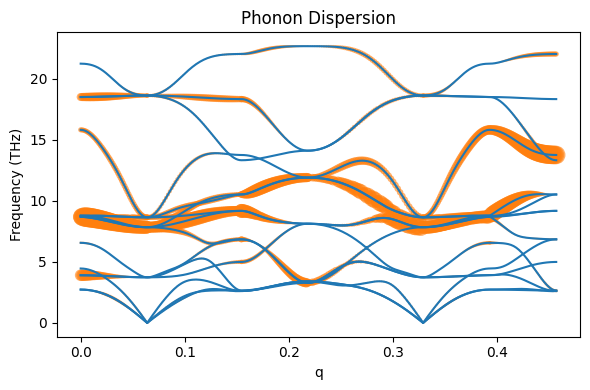

In [ ]:

# unit_cell_phonons["frequencies"]: shape [nq, nbranches]
# unit_cell_phonons["q"]: shape [nq]

freqs = np.array(unit_cell_phonons["frequencies"])  # [nq, nbranches]
q = np.array(unit_cell_phonons["qpoints"])  # [nq]

plt.figure(figsize=(6,4))
for b in range(freqs.shape[1]):
    plt.plot(q, freqs[:, b], color="C0")

# Overlay scatter plot: point size proportional to projection_modulus
# Normalize projection_modulus for point size scaling
proj = projections_modulus
min_size = 0
max_size = 200
proj_norm = (proj - proj.min()) / max(proj.max() - proj.min(), 1e-12)
sizes = min_size + proj_norm**2 * (max_size - min_size)

for b in range(freqs.shape[1]):
    plt.scatter(q, freqs[:, b], s=sizes[:, b], color="C1", alpha=0.6, edgecolors='none')

plt.xlabel("q")
plt.ylabel("Frequency (THz)")
plt.title("Phonon Dispersion")
plt.tight_layout()
plt.show()


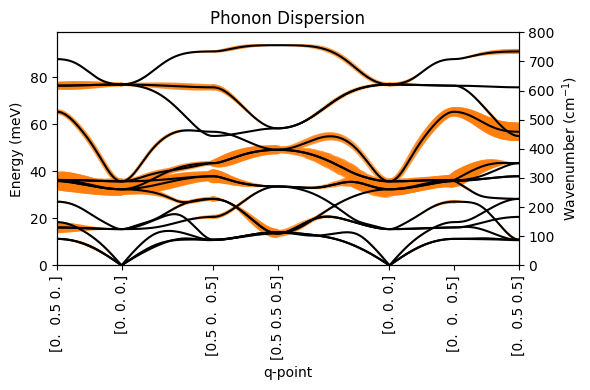

In [26]:
import matplotlib.pyplot as plt

# unit_cell_phonons["frequencies"]: shape [nq, nbranches]
# unit_cell_phonons["q"]: shape [nq]

# Conversion factor: 1 THz = 4.13567 meV (h * 1e12 / e, where h = 4.13567e-15 eV*s)
THZ_TO_MEV = 4.13567

freqs_thz = np.array(unit_cell_phonons["frequencies"])  # [nq, nbranches]
freqs = freqs_thz * THZ_TO_MEV  # convert to meV
q = np.array(unit_cell_phonons["qpoints"])  # [nq]


qpf = unit_cell_phonons["qpoints_frac"]
q_ticks = [i for i in range(len(qpf)-1) if np.allclose(qpf[i], qpf[i+1])]
q_ticks.append(0)
q_ticks.append(len(q)-1)

plt.figure(figsize=(6,4))
for b in range(freqs.shape[1]):
    plt.plot(q, freqs[:, b], color="black")

# Overlay scatter plot: point size proportional to projection_modulus
# Normalize projection_modulus for point size scaling
proj = projections_modulus
min_size = 0
max_size = 200
proj_norm = (proj - proj.min()) / max(proj.max() - proj.min(), 1e-12)
sizes = min_size + proj_norm**2 * (max_size - min_size)

for b in range(freqs.shape[1]):
    plt.scatter(q, freqs[:, b], s=sizes[:, b], color="C1", alpha=0.6, edgecolors='none')

plt.xticks(q[q_ticks], [f"{qpf[i]}" for i in q_ticks], rotation=90)
x_ticks = ["G", "M", "R", "G", "X", "X", "M"]
#plt.xticks(q[q_ticks], x_ticks, fontsize=7)

MEV_TO_CM1 = 8.06554
plt.ylim(0, 800/MEV_TO_CM1)
plt.xlim(q.min(), q.max())
ax = plt.gca()
ax2 = ax.twinx()
# Conversion factor: 1 meV = 8.06554 cm^-1 (1 meV = 8.06554 cm^-1)
ax2.set_ylim(ax.get_ylim()[0] * MEV_TO_CM1, ax.get_ylim()[1] * MEV_TO_CM1)
ax2.set_ylabel("Wavenumber (cm$^{-1}$)")



ax.set_xlabel("q-point")
ax.set_ylabel("Energy (meV)")
plt.title("Phonon Dispersion")
plt.tight_layout()
plt.savefig("phonon_dispersion.svg", format="svg")
plt.show()


In [27]:
print(unit_cell_phonons["qpoints"])
print(unit_cell_phonons["qpoints_frac"])
for qp in unit_cell_phonons["qpoints_frac"]:
    print(qp)

    # Find indices where two sequential elements of unit_cell_phonons["qpoints_frac"] are the same



[0.0, 0.0012792, 0.0025584, 0.0038376, 0.0051169, 0.0063961, 0.0076753, 0.0089545, 0.0102337, 0.0115129, 0.0127921, 0.0140713, 0.0153506, 0.0166298, 0.017909, 0.0191882, 0.0204674, 0.0217466, 0.0230258, 0.024305, 0.0255843, 0.0268635, 0.0281427, 0.0294219, 0.0307011, 0.0319803, 0.0332595, 0.0345387, 0.035818, 0.0370972, 0.0383764, 0.0396556, 0.0409348, 0.042214, 0.0434932, 0.0447724, 0.0460517, 0.0473309, 0.0486101, 0.0498893, 0.0511685, 0.0524477, 0.0537269, 0.0550061, 0.0562854, 0.0575646, 0.0588438, 0.060123, 0.0614022, 0.0626814, 0.0639606, 0.0639606, 0.0657697, 0.0675788, 0.0693879, 0.0711969, 0.073006, 0.0748151, 0.0766242, 0.0784333, 0.0802423, 0.0820514, 0.0838605, 0.0856696, 0.0874787, 0.0892877, 0.0910968, 0.0929059, 0.094715, 0.0965241, 0.0983331, 0.1001422, 0.1019513, 0.1037604, 0.1055695, 0.1073785, 0.1091876, 0.1109967, 0.1128058, 0.1146149, 0.1164239, 0.118233, 0.1200421, 0.1218512, 0.1236603, 0.1254693, 0.1272784, 0.1290875, 0.1308966, 0.1327057, 0.1345147, 0.1363238, 0

In [28]:
with open("example/mesh_single.yaml", "r") as f:
    data = yaml.safe_load(f)
unit_cell_mesh_phonons, unit_cell_mesh_meta = parse_band_yaml(data)

In [29]:
unit_eigvecs_mesh = np.asarray(unit_cell_mesh_phonons["eigenvectors"])  # [nq, nbranches, natoms, 3]
qpoints_frac_mesh  = np.asarray(unit_cell_mesh_phonons["qpoints_frac"], dtype=float)         # [nq, 3]
nq_mesh, nbranches_mesh, natoms_mesh, _ = unit_eigvecs_mesh.shape

supercell_eigenvectors_mesh = np.empty((nq_mesh, nbranches_mesh, natoms_mesh*nx*ny*nz, 3), dtype=np.complex128)

for iq in range(nq_mesh):
    qf = qpoints_frac_mesh[iq]  # (q1, q2, q3) in fractional coords
    for b in range(nbranches_mesh):
        eig_uc = unit_eigvecs_mesh[iq, b]            # (natoms, 3), complex
        eig_sc = build_supercell_mode_stepwise(eig_uc, qf, nx, ny, nz)
        supercell_eigenvectors_mesh[iq, b] = eig_sc

rearranged_supercell_eigenvectors_mesh = []
for q in range(len(supercell_eigenvectors_mesh)):
    q_eigvecs = []
    for b in range(len(supercell_eigenvectors_mesh[q])):
        eigvecs = supercell_eigenvectors_mesh[q][b]  # [supercell_natoms, 3]
        # Rearranged: [eigvecs[mapping[0]], eigvecs[mapping[1]], ..., eigvecs[mapping[-1]]]
        eigvecs_rearr = np.array([eigvecs[j] for j in mapping])
        q_eigvecs.append(eigvecs_rearr)
    rearranged_supercell_eigenvectors_mesh.append(q_eigvecs)
# rearranged_supercell_eigenvectors: [nq][nbranches][len(ts_atoms)-1][3]


In [30]:
projections_modulus_mesh = []
for q in range(len(rearranged_supercell_eigenvectors_mesh)):
    q_proj = []
    for b in range(len(rearranged_supercell_eigenvectors_mesh[q])):
        eigvec = rearranged_supercell_eigenvectors_mesh[q][b]  # shape: (len(ts_atoms)-1, 3)
        eigvec_flat = eigvec.flatten()  # shape: ((len(ts_atoms)-1)*3,)
        # If eigenvectors are complex, use conjugate for projection
        proj = np.vdot(eigvec_flat, dx_vec_flat)  # vdot does conjugate on first arg  
        q_proj.append(np.abs(proj))
    projections_modulus_mesh.append(q_proj)
projections_modulus_mesh = np.array(projections_modulus_mesh)  # shape: (nq, nbranches)
print(projections_modulus_mesh.shape)



(1331, 15)


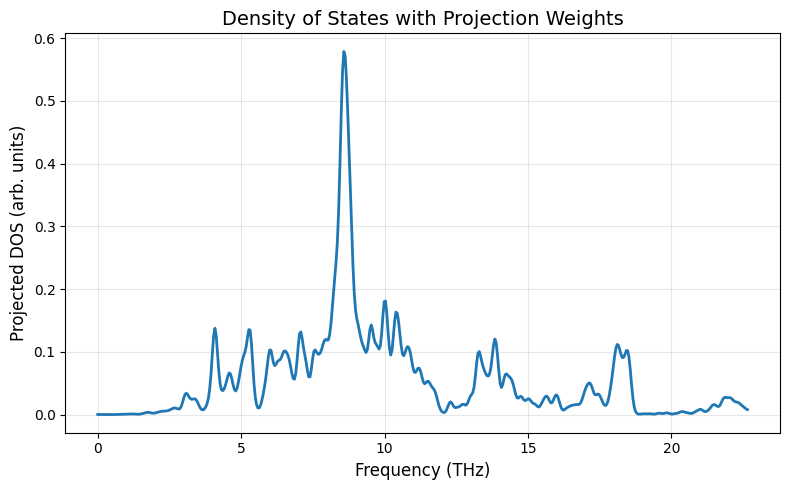

In [54]:
# Flatten projections to get energy bars
energy_bars = projections_modulus_mesh.flatten()**2  # shape: (nq * nbranches,)

# Get corresponding frequencies for each projection
frequencies_mesh = np.asarray(unit_cell_mesh_phonons["frequencies"])  # [nq, nbranches]
frequencies_flat = frequencies_mesh.flatten()  # shape: (nq * nbranches,)

# Apply Gaussian smoothing to create density of states
from scipy.ndimage import gaussian_filter1d

# Create energy grid for DOS
energy_min = frequencies_flat.min()
energy_max = frequencies_flat.max()
energy_grid = np.linspace(energy_min, energy_max, 500)

# Bin the weighted projections onto the energy grid
dos = np.zeros_like(energy_grid)
bin_width = energy_grid[1] - energy_grid[0]

for freq, weight in zip(frequencies_flat, energy_bars):
    # Find nearest bin
    idx = np.argmin(np.abs(energy_grid - freq))
    dos[idx] += weight

# Apply Gaussian smoothing
sigma = 2  # smoothing parameter (adjust as needed)
dos_smoothed = gaussian_filter1d(dos, sigma=sigma)

# Plot the density of states
plt.figure(figsize=(8, 5))
plt.plot(energy_grid, dos_smoothed, linewidth=2)
plt.xlabel('Frequency (THz)', fontsize=12)
plt.ylabel('Projected DOS (arb. units)', fontsize=12)
plt.title('Density of States with Projection Weights', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [9]:

phonons_bsy = phonopy.load("example/phonopy_bsy.yaml", force_constants_filename="example/FORCE_CONSTANTS_bsy")

In [10]:
print(phonons_bsy)

In [32]:
mesh = [16,16,16]
phonons_bsy.run_mesh(mesh, with_eigenvectors=True, is_gamma_center=True, is_mesh_symmetry=False)


In [42]:
bsy_eigenvectors = phonons_bsy.get_mesh_dict()["eigenvectors"]
bsy_frequencies = phonons_bsy.get_mesh_dict()["frequencies"]

In [90]:
projections_modulus_bsy_mesh = []
for q in range(len(bsy_eigenvectors)):
    q_proj = []
    for b in range(len(bsy_eigenvectors[q])):
        eigvec = bsy_eigenvectors[q].transpose()[b]  # shape: (len(ts_atoms)-1, 3)
        eigvec_flat = eigvec.flatten()  # shape: ((len(ts_atoms)-1)*3,)
        # If eigenvectors are complex, use conjugate for projection
        proj = np.vdot(eigvec_flat, dx_vec_flat)  # vdot does conjugate on first arg  
        q_proj.append(np.abs(proj))
    projections_modulus_bsy_mesh.append(q_proj)
projections_modulus_bsy_mesh = np.array(projections_modulus_bsy_mesh)  # shape: (nq, nbranches)
print(projections_modulus_bsy_mesh.shape)

(4096, 120)


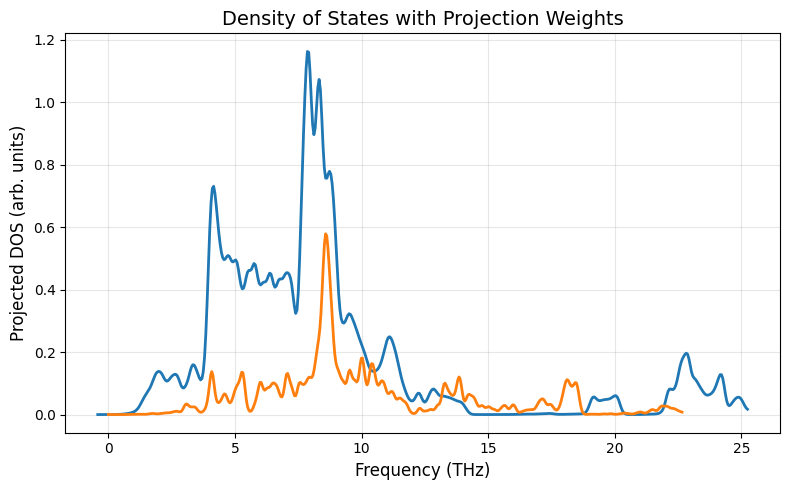

In [91]:
# Flatten projections to get energy bars
energy_bars = projections_modulus_bsy_mesh.flatten()**2  # shape: (nq * nbranches,)

# Get corresponding frequencies for each projection
frequencies_bsy_mesh = np.asarray(bsy_frequencies)  # [nq, nbranches]
frequencies_bsy_flat = frequencies_bsy_mesh.flatten()  # shape: (nq * nbranches,)

# Create energy grid for DOS
energy_min = frequencies_bsy_flat.min()
energy_max = frequencies_bsy_flat.max()
energy_grid_bsy = np.linspace(energy_min, energy_max, 500)

# Bin the weighted projections onto the energy grid
dos_bsy = np.zeros_like(energy_grid_bsy)
bin_width = energy_grid_bsy[1] - energy_grid_bsy[0]

for freq, weight in zip(frequencies_bsy_flat, energy_bars):
    # Find nearest bin
    idx = np.argmin(np.abs(energy_grid_bsy - freq))
    dos_bsy[idx] += weight

# Apply Gaussian smoothing
sigma = 2  # smoothing parameter (adjust as needed)
dos_bsy_smoothed = gaussian_filter1d(dos_bsy, sigma=sigma)

# Plot the density of states
plt.figure(figsize=(8, 5))
plt.plot(energy_grid_bsy, dos_bsy_smoothed, linewidth=2)
plt.plot(energy_grid, dos_smoothed, linewidth=2)
plt.xlabel('Frequency (THz)', fontsize=12)
plt.ylabel('Projected DOS (arb. units)', fontsize=12)
plt.title('Density of States with Projection Weights', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

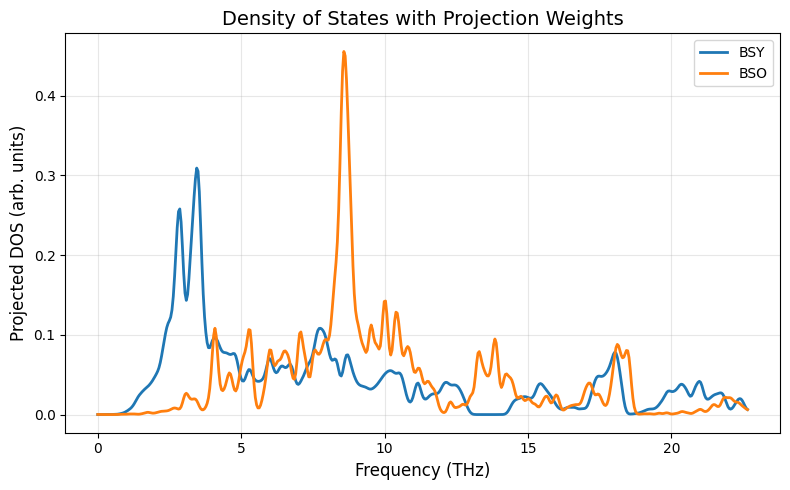

In [60]:
# Normalize DOS so that integral equals 1
dos_smoothed_normalized = dos_smoothed / np.trapz(dos_smoothed, energy_grid)
dos_bsy_smoothed_normalized = dos_bsy_smoothed / np.trapz(dos_bsy_smoothed, energy_grid)


# Plot the density of states
plt.figure(figsize=(8, 5))
plt.plot(energy_grid, dos_bsy_smoothed_normalized, linewidth=2, label="BSY")
plt.plot(energy_grid, dos_smoothed_normalized, linewidth=2, label="BSO")
plt.xlabel('Frequency (THz)', fontsize=12)
plt.ylabel('Projected DOS (arb. units)', fontsize=12)
plt.title('Density of States with Projection Weights', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
phonons_sc = phonopy.load("example/phonopy_sc.yaml", force_constants_filename="example/FORCE_CONSTANTS_sc")
mesh = [16,16,16]
phonons_sc.run_mesh(mesh, with_eigenvectors=True, is_gamma_center=True, is_mesh_symmetry=False)


In [88]:
sc_eigenvectors = phonons_sc.get_mesh_dict()["eigenvectors"]
sc_frequencies = phonons_sc.get_mesh_dict()["frequencies"]
projections_modulus_sc_mesh = []

for q in range(len(sc_eigenvectors)):
    q_proj = []
    for b in range(len(sc_eigenvectors[q])):
        eigvec = sc_eigenvectors[q].transpose()[b]  # shape: (len(ts_atoms)-1, 3)
        eigvec_flat = eigvec.flatten()  # shape: ((len(ts_atoms)-1)*3,)
        # If eigenvectors are complex, use conjugate for projection
        proj = np.vdot(eigvec_flat, dx_vec_flat)  # vdot does conjugate on first arg  
        q_proj.append(np.abs(proj))
    projections_modulus_sc_mesh.append(q_proj)
projections_modulus_sc_mesh = np.array(projections_modulus_sc_mesh)  # shape: (nq, nbranches)
print(projections_modulus_sc_mesh.shape)

# Flatten projections to get energy bars
energy_bars = projections_modulus_sc_mesh.flatten()**2  # shape: (nq * nbranches,)

# Get corresponding frequencies for each projection
frequencies_sc_mesh = np.array(sc_frequencies)  # [nq, nbranches]
frequencies_sc_flat = frequencies_sc_mesh.flatten()  # shape: (nq * nbranches,)


# Create energy grid for DOS
energy_min = frequencies_sc_flat.min()
energy_max = frequencies_sc_flat.max()
energy_grid_sc = np.linspace(energy_min, energy_max, 500)

# Bin the weighted projections onto the energy grid
dos_sc = np.zeros_like(energy_grid_sc)
bin_width = energy_grid_sc[1] - energy_grid_sc[0]

for freq, weight in zip(frequencies_sc_flat, energy_bars):
    # Find nearest bin
    idx = np.argmin(np.abs(energy_grid_sc - freq))
    dos_sc[idx] += weight

# Apply Gaussian smoothing
sigma = 2  # smoothing parameter (adjust as needed)
dos_sc_smoothed = gaussian_filter1d(dos_sc, sigma=sigma)


(4096, 120)


In [79]:
for i in sc_eigenvectors[1][-1]:
    print(i)

(0.025302771466307414+0.0019362705758334264j)
(-0.031730667935943084-0.234973031823717j)
(6.279629577136806e-16+2.200045792824767e-16j)
(-0.3272292590714952+0.04975688227091049j)
(0.1237507153375574-0.011429919827917944j)
(-5.895295102781306e-15-1.0980711511506674e-14j)
(0.15609505067582752-0.1230601907231874j)
(0.28997365659211183+0.020989303629614747j)
(-0.16901896956850201+0.007235799336747722j)
(0.19570387896252925+0.24089681106111077j)
(-1.813653394133752e-15+4.867634073590921e-15j)
(-4.39722043499291e-14-4.659770833082e-14j)
(-1.44953493652622e-14+1.0172418463127997e-14j)
(-1.100161628464491e-14-1.49741330446318e-14j)
(0.192962663426691-0.14031249863727263j)
(0.23858371015716323+3.091806421672574e-10j)
(0.172031095982217+0.19196132154747267j)
(-0.0689302008904992-0.20711938844580327j)
(2.192178730209271e-13-6.182771308815838e-14j)
(-0.3198362730651122+0.0327732715721071j)
(0.1419292389750922-0.025577874765691358j)
(-9.586081928247836e-15+2.3314683517128287e-15j)
(-0.0005421202331

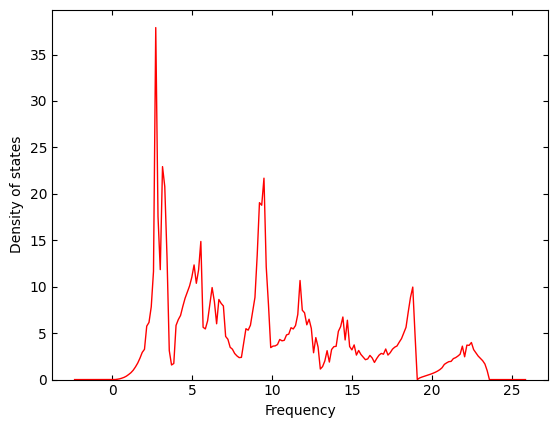

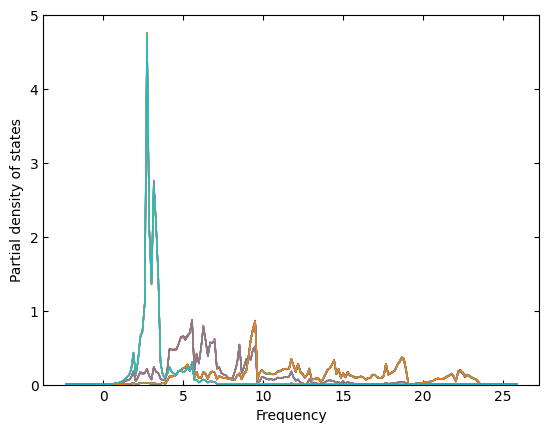

In [70]:
phonons_sc.run_total_dos()
phonons_sc.plot_total_dos().show()
phonons_sc.auto_projected_dos(plot=True).show()


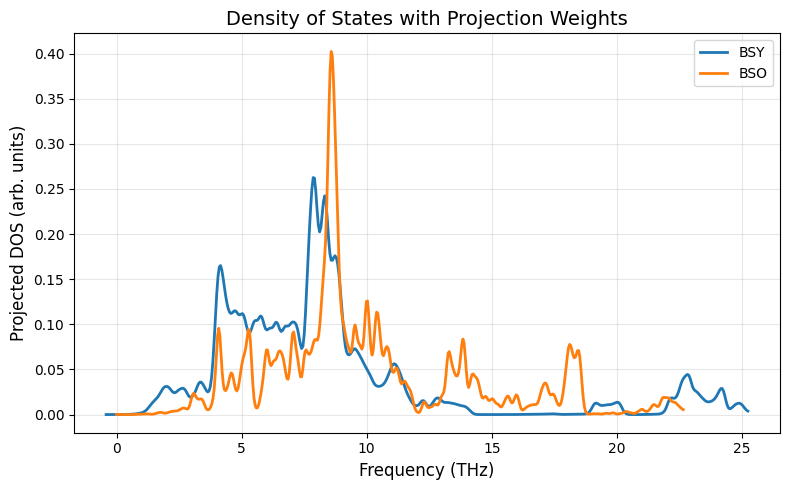

In [92]:
# Normalize DOS so that integral equals 1
dos_smoothed_normalized = dos_smoothed / np.trapz(dos_smoothed, energy_grid_bsy)
dos_bsy_smoothed_normalized = dos_bsy_smoothed / np.trapz(dos_bsy_smoothed, energy_grid_bsy)
dos_sc_smoothed_normalized = dos_sc_smoothed / np.trapz(dos_sc_smoothed, energy_grid_sc)


# Plot the density of states
plt.figure(figsize=(8, 5))
plt.plot(energy_grid_bsy, dos_bsy_smoothed_normalized, linewidth=2, label="BSY")
plt.plot(energy_grid, dos_smoothed_normalized, linewidth=2, label="BSO")
plt.xlabel('Frequency (THz)', fontsize=12)
plt.ylabel('Projected DOS (arb. units)', fontsize=12)
plt.title('Density of States with Projection Weights', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()